In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout,Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
SEED = 1987
data_dir = ''
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [3]:
# This part is optional for if you want to train only on most popular classes. 
# NUM_CLASSES = 16
# selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
# labels = labels[labels['breed'].isin(selected_breed_list)]

In [4]:
labels['target'] = 1
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot.values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [5]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

In [6]:
INPUT_SIZE = 224
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

10222it [00:38, 268.53it/s]


Train Images shape: (10222, 224, 224, 3) size: 1,538,697,216


In [7]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))

((8140, 224, 224, 3), (2082, 224, 224, 3), (8140, 121), (2082, 121))


In [8]:
del x_train

In [9]:
POOLING='none'
model_vgg16_bottleneck = VGG16(weights='imagenet',include_top=False, input_shape = (INPUT_SIZE,INPUT_SIZE,3),pooling=POOLING)
model_vgg16 = VGG16(weights='imagenet',include_top=True, input_shape = (INPUT_SIZE,INPUT_SIZE,3),pooling=POOLING)
train_vgg_bf = model_vgg16_bottleneck.predict(Xtr, batch_size=32, verbose=1)

8140/8140 [==============================] - ETA: 9: - ETA: 5: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA:

In [10]:
valid_vgg_bf = model_vgg16_bottleneck.predict(Xv, batch_size=32, verbose=2)
print(train_vgg_bf.shape,valid_vgg_bf.shape)

(8140, 7, 7, 512) (2082, 7, 7, 512)


In [11]:
fc1_layer = model_vgg16.get_layer("fc1")
inputs = Input(shape=(7,7,512))
x = Flatten()(inputs)
x = fc1_layer(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
predictions = Dense(ytr.shape[1]-1, activation='softmax',name='Last_softmax')(x) 
model = Model(inputs, outputs=predictions)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096)              16384     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2097664   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
__________

In [13]:
for i, layer in enumerate(model.layers[:-6]):
   layer.trainable = False
   print(i, layer.name,layer.trainable)   

0 input_3 False
1 flatten_1 False
2 fc1 False


In [14]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy',metrics = ["accuracy"])

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=2)
history = model.fit(x = train_vgg_bf, y = ytr[:,1:], epochs = 80, batch_size = 8140,
          validation_data = [valid_vgg_bf,yv[:,1:]],callbacks=[reduce_lr], verbose=1)

Train on 8140 samples, validate on 2082 samples
Epoch 1/80
8140/8140 [==============================] - 2s 286us/step - loss: 8.0514 - acc: 0.0085 - val_loss: 4.6413 - val_acc: 0.0303
Epoch 2/80
8140/8140 [==============================] - 2s 188us/step - loss: 7.7228 - acc: 0.0103 - val_loss: 4.2100 - val_acc: 0.1134
Epoch 3/80
8140/8140 [==============================] - 2s 188us/step - loss: 7.1076 - acc: 0.0210 - val_loss: 3.7873 - val_acc: 0.2310
Epoch 4/80
8140/8140 [==============================] - 2s 186us/step - loss: 6.7008 - acc: 0.0296 - val_loss: 3.4037 - val_acc: 0.3160
Epoch 5/80
8140/8140 [==============================] - 2s 194us/step - loss: 6.1858 - acc: 0.0430 - val_loss: 3.0726 - val_acc: 0.3703
Epoch 6/80
8140/8140 [==============================] - 2s 193us/step - loss: 5.7489 - acc: 0.0613 - val_loss: 2.7917 - val_acc: 0.4193
Epoch 7/80
8140/8140 [==============================] - 2s 190us/step - loss: 5.3270 - acc: 0.0893 - val_loss: 2.5600 - val_acc: 0.4544


Epoch 61/80
8140/8140 [==============================] - 2s 189us/step - loss: 1.3993 - acc: 0.6039 - val_loss: 0.9271 - val_acc: 0.7286
Epoch 62/80
8140/8140 [==============================] - 2s 186us/step - loss: 1.4118 - acc: 0.6014 - val_loss: 0.9246 - val_acc: 0.7296
Epoch 63/80
8140/8140 [==============================] - 2s 188us/step - loss: 1.3782 - acc: 0.6145 - val_loss: 0.9222 - val_acc: 0.7305
Epoch 64/80
8140/8140 [==============================] - 2s 188us/step - loss: 1.3654 - acc: 0.6131 - val_loss: 0.9198 - val_acc: 0.7310
Epoch 65/80
8140/8140 [==============================] - 2s 187us/step - loss: 1.3371 - acc: 0.6182 - val_loss: 0.9174 - val_acc: 0.7310
Epoch 66/80
8140/8140 [==============================] - 2s 191us/step - loss: 1.3477 - acc: 0.6243 - val_loss: 0.9149 - val_acc: 0.7334
Epoch 67/80
8140/8140 [==============================] - 2s 188us/step - loss: 1.3340 - acc: 0.6216 - val_loss: 0.9126 - val_acc: 0.7344
Epoch 68/80
8140/8140 [==================

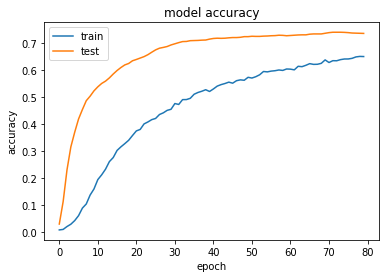

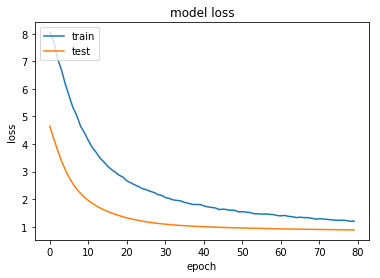

In [17]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save_weights('trained_weights_vgg16_stage1.h5')

In [ ]:
#model.load_weights('trained_weights_resenet50_stage1.h5')

In [ ]:
for i, layer in enumerate(model.layers):
   layer.trainable = True

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy',metrics = ["accuracy"])
model.fit(x = Xtr, y = ytr[:,1:], epochs = 20, batch_size = 4,validation_data = [Xv,yv[:,1:]],callbacks=[reduce_lr, early_stopping])

In [ ]:
model.save_weights('trained_weights_vgg16.h5')

Creating submission file

In [ ]:
INPUT_SIZE = 224
for i, img_id in tqdm(enumerate(sample_submission['id'])):
    img = read_img(img_id, 'test', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    y = model.predict(x)
    sample_submission.iloc[i,1:121] = np.asarray(y[0,0:120])

In [ ]:
#sample_submission.iloc[1,1:121] = np.asarray(y[0,0:120])

In [ ]:
#sample_submission.head()

In [ ]:
sample_submission.to_csv('submission4.csv',index=False)